 <div class="alert alert-block alert-info">
    <b>Note:</b> 
    Interchange is in the process of replacing ParmEd in many workflows, but it still in an alpha testing phase. Our internal tests indicate it is reliable for many small-molecule systems, but it is not yet reliable for complex, multi-component systems and there are likely still rough edges throughout. Feedback is welcome on the <a href=https://github.com/openforcefield/openff-interchange/issues/>Interchange issue tracker.</a></div>

## Using OpenFF force fields in Amber and GROMACS

The Open Forcefield Toolkit can create parametrized `openmm.System` objects that can be natively simulated with OpenMM. This example shows the Interchange project can enable parallel workflows using Amber and GROMACS.

### Preparing an OpenFF Topology

We start by loading a PDB file containing one copy of ethanol and cyclohexane. Our goal is to create an OpenFF `Topology` object describing this system that we can parametrize with the SMIRNOFF-format "Sage" force field.

The two `Molecule` objects created from the SMILES strings can contain information such as partial charges and stereochemistry that is not included in an OpenMM topology. In this example, partial charges are not explicitly given, and `ForceField` will assign AM1/BCC charges as specified by the "Sage" force field. Note that the OpenFF Toolkit produces partial charges that do not depend on the input conformation of parameterized molecules. See the [FAQ](https://open-forcefield-toolkit.readthedocs.io/en/latest/faq.html#the-partial-charges-generated-by-the-toolkit-don-t-seem-to-depend-on-the-molecule-s-conformation-is-this-a-bug) for more information.

In [2]:
try:
    from openmm import app
except ImportError:
    from simtk.openmm import app

from openff.toolkit.topology import FrozenMolecule, Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
import pdb

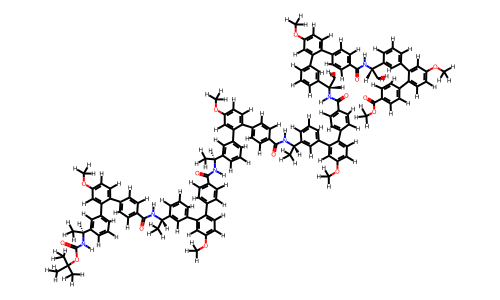

In [3]:
hexa_mop = Molecule.from_file("mop_hexamer_mbuild.mol")
hexa_mop

In [4]:
# Load the PDB file using OpenMM and save the OpenMM Topology
pdbfile = app.PDBFile("mop_hexamer_mbuild_renum.pdb")
omm_topology = pdbfile.topology
omm_topology

<Topology; 1 chains, 8 residues, 285 atoms, 302 bonds>

In [10]:
for r in omm_topology.residues():
    print(r)

<Residue 0 (HEX) of chain 0>
<Residue 1 (HEX) of chain 0>
<Residue 2 (HEX) of chain 0>
<Residue 3 (HEX) of chain 0>
<Residue 4 (HEX) of chain 0>
<Residue 5 (HEX) of chain 0>
<Residue 6 (CAP) of chain 0>
<Residue 7 (CAP) of chain 0>


In [5]:
# Create the OpenFF Topology.
off_topology = Topology.from_openmm(
    omm_topology, unique_molecules=[hexa_mop]
)


In [6]:
# Modified OpenFF to increase maxAtoms for AM1BCC method to 500 atoms
hexa_mop.compute_partial_charges_am1bcc()

### Preparing an OpenFF ForceField

Once the `ForceField` class is imported, the only decision to make is which force field to use. An exhaustive list of force fields released by the Open Force Field Initiative can be found [here](from openff.toolkit.typing.engines.smirnoff import ForceField
).

Here we will use force field from the "Sage" line.

In [7]:
forcefield = ForceField("openff-2.0.0.offxml")

### Preparing an OpenMM System

Once a force field and topology have been loaded, an `openmm.System` can be generated natively with the OpenFF Toolkit.

In [8]:
omm_system = forcefield.create_openmm_system(off_topology, charge_from_molecules = [hexa_mop])
omm_system

<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x7f757d40a6c0> >

### Preparing an Interchange object

To exports to engines other than OpenMM, we will make use of the [Interchange](https://openff-interchange.readthedocs.io/) project. There is a high-level `Interchange.from_smirnoff` function that consumes OpenFF Toolkit and ForceField objects and produces an `Interchange` object which can then be exported to formats understood by other molecular simulation engines. This extra step is needed to provide a clean interface between _applied_ parameters and engines. Note also that this step does not require an OpenMM System to be generated; `ForceField.create_openmm_system` does not need to be called to use Amber and GROMACS.

In [9]:
from openff.interchange.components.interchange import Interchange

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=off_topology,
)
interchange.positions = pdbfile.positions
interchange

/home/tfobe/anaconda3/envs/terphenyl/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tfobe/anaconda3/envs/terphenyl/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/tfobe/anaconda3/envs/terphenyl/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/tfobe/anaconda3/envs/terphenyl/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Interchange with 285 atoms, non-periodic topology

### Exporting to Amber and GROMACS files

Once an `Interchange` object has been constructed, its API can be used to export to files understood by GROMACS, Amber, and more.

In [10]:
# Export GROMACS files.
interchange.to_top("terphenyl_mop_hexamer.top")
interchange.to_gro("terphenyl_mop_hexamer.gro")

### Validating the conversion to Amber files

The Interchange project includes functions that take in an `Interchange` object and call out to simulation engines to run single-point energy calculations (with no minimization or dynamics) for the purpose of validating the export layer with each engine. Under the hood, each of these functions calls API points like those used above while converting to files understood by each engine. These rely on having each engine installed and accessible in the current `$PATH`.

In [11]:
from openff.interchange.drivers import get_gromacs_energies, get_openmm_energies

In [12]:
openmm_energies = get_openmm_energies(interchange)
openmm_energies.energies

{'Bond': 310.4259610353005 <Unit('kilojoule / mole')>,
 'Angle': 2299.380356828711 <Unit('kilojoule / mole')>,
 'Torsion': 438.1125499292022 <Unit('kilojoule / mole')>,
 'vdW': 600629692.3964148 <Unit('kilojoule / mole')>,
 'Electrostatics': -1275.0704405280267 <Unit('kilojoule / mole')>}

In [13]:
!cat terphenyl_mop_hexamer.top
!cat terphenyl_mop_hexamer.gro
amber_energies = get_gromacs_energies(interchange)
amber_energies.energies

; Generated by OpenFF Interchange
[ defaults ]
; nbfunc	comb-rule	gen-pairs	fudgeLJ	fudgeQQ
     1	     2	no     0.500000 0.833333

[ atomtypes ]
;type, bondingtype, mass, charge, ptype, sigma, epsilon
C1               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

O1               8 15.99943 0.0000000000000000 A     0.3039812205065809 0.8795023257036865

C2               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C3               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C4               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C5               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C6               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C7               6 12.01078 0.0000000000000000 A     0.3480646886945065 0.3635030558377792

C8               6 12.01078 0.0000000000000000 A     0.3480646

Generated by OpenFF
285
    1mop_h   C1    1  -0.30020000  -0.49110000   0.01170000
    1mop_h   O1    2  -0.38790000  -0.54070000  -0.06390000
    1mop_h   C2    3  -0.27170000  -0.34650000   0.01060000
    1mop_h   C3    4  -0.17350000  -0.29450000   0.09610000
    1mop_h   C4    5  -0.14500000  -0.15770000   0.09630000
    1mop_h   C5    6  -0.21380000  -0.07070000   0.01010000
    1mop_h   C6    7  -0.18310000   0.07440000   0.00930000
    1mop_h   C7    8  -0.05130000   0.12340000  -0.00910000
    1mop_h   C8    9  -0.02750000   0.26170000  -0.00110000
    1mop_h   C9   10  -0.13190000   0.35170000   0.02220000
    1mop_h   O2   11  -0.10170000   0.48850000   0.02850000
    1mop_h  C10   12  -0.19770000   0.59120000   0.05140000
    1mop_h  C11   13  -0.26260000   0.30260000   0.03800000
    1mop_h  C12   14  -0.28760000   0.16550000   0.03150000
    1mop_h  C13   15   0.06230000   0.03350000  -0.04080000
    1mop_h  C14   16   0.05580000  -0.05310000  -0.15100000
    1mop_h  C15 

{'Bond': 310.41937255859375 <Unit('kilojoule / mole')>,
 'Angle': 2299.380859375 <Unit('kilojoule / mole')>,
 'Torsion': 433.1090087890625 <Unit('kilojoule / mole')>,
 'vdW': 32521.362185701728 <Unit('kilojoule / mole')>,
 'Electrostatics': -1261.5623474121094 <Unit('kilojoule / mole')>}

### Appendix: Validating the conversion to GROMACS and LAMMPS files

If GROMACS and/or LAMMPS are installed on your machine, the same comparisons can also take place with those engines. They are available via `conda` by running a command like:

```conda install gromacs lammps -c conda-forge -c bioconda```

In [14]:
from distutils.spawn import find_executable
from pprint import pprint

from openff.interchange.drivers import get_gromacs_energies, get_lammps_energies

In [15]:
if find_executable("lmp_serial"):
    pprint(get_lammps_energies(interchange).energies)

In [16]:
if find_executable("gmx"):
    pprint(get_gromacs_energies(interchange).energies)

{'Angle': <Quantity(2299.38086, 'kilojoule / mole')>,
 'Bond': <Quantity(310.419373, 'kilojoule / mole')>,
 'Electrostatics': <Quantity(-1261.56235, 'kilojoule / mole')>,
 'Torsion': <Quantity(433.109009, 'kilojoule / mole')>,
 'vdW': <Quantity(32521.3622, 'kilojoule / mole')>}


Finally, there is a helper function `get_summary_data` that will attempt to run drivers of each engine. A summary reported is prepared as a Pandas `DataFrame`.